In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from torch import nn
import torch
import time
import unet

import swyft
import pylab as plt
import scipy.stats.distributions as dist
from astropy.visualization import make_lupton_rgb



torch.set_float32_matmul_precision('medium')
DEVICE = "cuda"

/home/cweniger/.pyenv/versions/3.10.11/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Generative model

In [3]:
bounds = None

In [54]:
class SimulatorBlob(swyft.Simulator):
    def __init__(self, bounds1 = None, bounds2 = None, Npix = 64, sigma = 0.1):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.theta_sampler = swyft.RectBoundSampler([dist.uniform(4., 0.1)])
        self.bounds1 = bounds1
        self.bounds2 = bounds2
        self.Npix = Npix
        self.sigma = sigma
        self.powersampler = swyft.utils.PowerSpectrumSampler(Npix)
        self.sigma = torch.ones(Npix, Npix)*0.1
#        self.sigma[:,:Npix//2] *= 1000
        
    def sample_delta1(self, theta):
        if self.bounds1 is not None:
            i = np.random.randint(len(self.bounds1))
            return torch.tensor(self.bounds1[i])
        else:
            return self.powersampler.sample(lambda k: 1e6*3*(k/0.5)**-theta[0])
        
    def sample_delta2(self, theta):
        if self.bounds2 is not None:
            i = np.random.randint(len(self.bounds2))
            return torch.tensor(self.bounds2[i])
        else:
            return self.powersampler.sample(lambda k: 1e6*3*(k/0.5)**-theta[0])
            
    def build(self, graph):
        theta = graph.node("theta", self.theta_sampler)
        delta1 = graph.node("delta1", self.sample_delta1, theta)
        delta2 = graph.node("delta2", self.sample_delta2, theta)
        rho1 = graph.node("rho1", lambda delta1: torch.exp(delta1/5).unsqueeze(0)*torch.tensor([1, 2, 10]).view(3, 1, 1), delta1)
        rho2 = graph.node("rho2", lambda delta2: torch.exp(delta2/5).unsqueeze(0)*torch.tensor([10, 2, 1]).view(3, 1, 1), delta2)
        mu = graph.node("mu", lambda rho1, rho2: rho1 + rho2, rho1, rho2)
        x = graph.node("x", lambda mu: mu + torch.randn(self.Npix, self.Npix)*self.sigma, mu)

/home/cweniger/.pyenv/versions/3.10.11/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


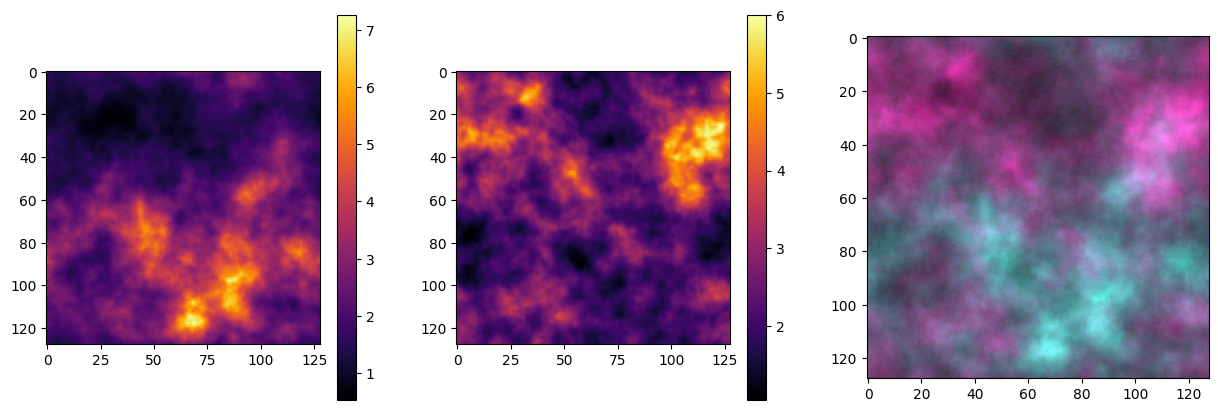

In [5]:
NPIX = 128
sim = SimulatorBlob(Npix = NPIX)
sample0 = sim.sample()
plt.figure(figsize = (15, 5))
plt.subplot(131)
plt.imshow(sample0['rho1'].mean(0), cmap = 'inferno')
plt.colorbar()
plt.subplot(132)
plt.imshow(sample0['rho2'].mean(0), cmap = 'inferno')
plt.colorbar()
plt.subplot(133)

#img = torch.tensor(sample0['x']).permute(1, 2, 0)
#img = img/img.max()
img = torch.tensor(sample0['x'])
img = make_lupton_rgb(img[0]/img[0].max(), img[2]/img[2].max(), img[1]/img[1].max(), stretch=1, Q = 0.01)
plt.imshow(img)



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 674.05it/s]


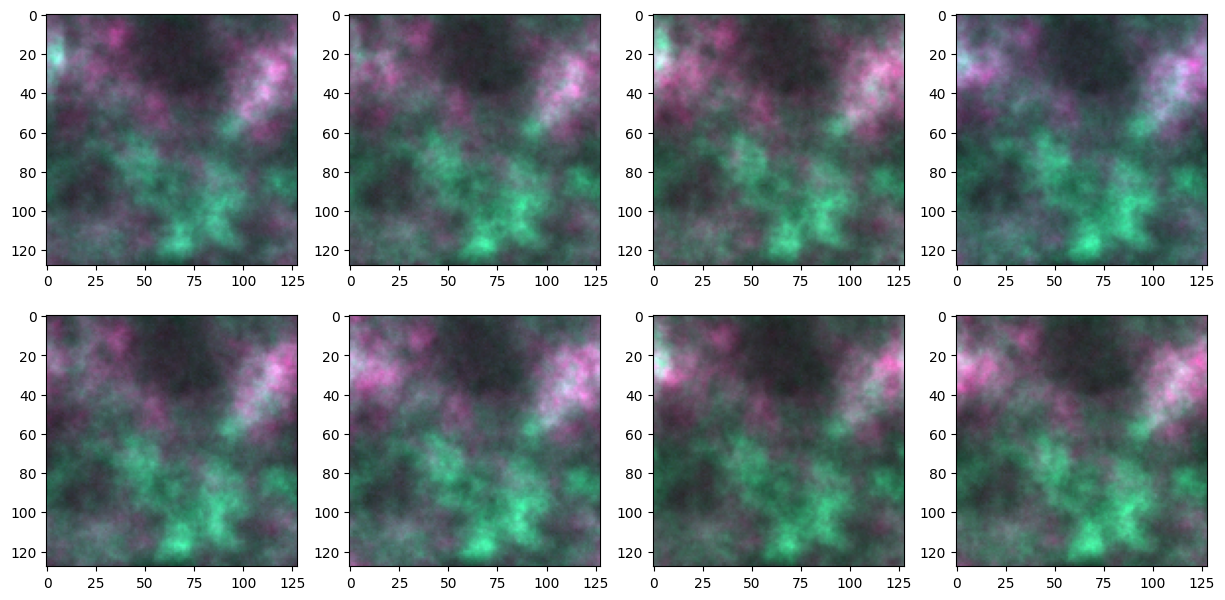

In [56]:
sim = SimulatorBlob(Npix = NPIX, bounds1 = bounds1, bounds2 = bounds2)
samples = sim.sample(8)
plt.figure(figsize = (15, 15))
for i in range(8):
    plt.subplot(4, 4, i+1)
    img = torch.tensor(samples[i]['x'])
    img = make_lupton_rgb(img[0]/img[0].max(), img[2]/img[2].max(), img[1]/img[1].max(), stretch=1, Q = 0.01)
    plt.imshow(img)

### Inference network

In [8]:
class Network(swyft.SwyftModule):
    def __init__(self, lr=1e-3, N = 1024):
        super().__init__()
        self.optimizer_init = swyft.AdamOptimizerInit(lr=1e-4, lrs_factor=0.1, lrs_patience=3)
        self.N = N
        self.lre1 = swyft.LogRatioEstimator_Gaussian_Autoregressive_X_module_based(
            self.N**2, "mu", minstd = 1e-5, momentum=0.02)
        self.lre2 = swyft.LogRatioEstimator_Gaussian_Autoregressive_X_module_based(
            self.N**2, "mu", minstd = 1e-5, momentum=0.02)
        self.unet1 = unet.UNet(3, 1, s = 4)
        self.unet2 = unet.UNet(3, 1, s = 4)
        
    def embed1(self, x):
        x = self.unet1(x).squeeze(1)
        x = x.view(-1, self.N**2)
        return x

    def embed2(self, x):
        x = self.unet2(x).squeeze(1)
        x = x.view(-1, self.N**2)
        return x

    def forward(self, A, B):
        rhoA = self.embed1(A['x'])
        rhoB = self.embed1(B['x'])
        delta1B = B['delta1'].view(-1, self.N**2)
        result1 = self.lre1(rhoA, rhoB, delta1B)
        
        rhoA = self.embed2(A['x'])
        rhoB = self.embed2(B['x'])
        delta2B = B['delta2'].view(-1, self.N**2)
        result2 = self.lre2(rhoA, rhoB, delta2B)

        return result1, result2

### Inference

In [37]:
sim = SimulatorBlob(Npix = NPIX, bounds = bounds)
samples = sim.sample(1000, exclude = ['pk_fn'])
#net.cpu(); net.float()
dm = swyft.SwyftDataModule(samples, fractions = [0.9, 0.1, 0.0], batch_size = 64)
net = Network(N = NPIX)
trainer = swyft.SwyftTrainer(accelerator = "gpu", devices = 1, max_epochs = 50)
trainer.fit(net, dm)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1061.66it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                                                     | Params
-----------------------------------------------------------------------------------
0 | lre1  | LogRatioEstimator_Gaussian_Autoregressive_X_module_based | 0     
1 | lre2  | LogRatioEstimator_Gaussian_Autoregressive_X_module_based | 0     
2 | unet1 | UNet                                                     | 1.9 M 
3 | unet2 | UNet                                                     | 1.9 M 
-----------------------------------------------------------------------------------
3.9 M     Trainable params
0         Non-trainable params
3.9 M     Total params
15.541    Total

Epoch 0:  88%|████████████████████████████████████████████████████████████████████▊         | 15/17 [00:03<00:00,  4.20it/s, loss=1.13e+05, v_num=242]
Validation: 0it [00:00, ?it/s]
Epoch 1:  88%|███████████████████████████████████████████████████▏      | 15/17 [00:03<00:00,  4.23it/s, loss=-3.03e+03, v_num=242, val_loss=-2.25e+3]
Validation: 0it [00:00, ?it/s]
Epoch 2:  88%|███████████████████████████████████████████████████▏      | 15/17 [00:03<00:00,  4.21it/s, loss=-8.04e+03, v_num=242, val_loss=-7.47e+3]
Validation: 0it [00:00, ?it/s]
Epoch 3:  88%|███████████████████████████████████████████████████▏      | 15/17 [00:03<00:00,  4.21it/s, loss=-1.09e+04, v_num=242, val_loss=-1.06e+4]
Validation: 0it [00:00, ?it/s]
Epoch 4:  88%|███████████████████████████████████████████████████▏      | 15/17 [00:03<00:00,  4.23it/s, loss=-1.33e+04, v_num=242, val_loss=-1.32e+4]
Validation: 0it [00:00, ?it/s]
Epoch 5:  88%|███████████████████████████████████████████████████▏      | 15/17 [00:03<00:

/home/cweniger/.pyenv/versions/3.10.11/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


### Evaluation

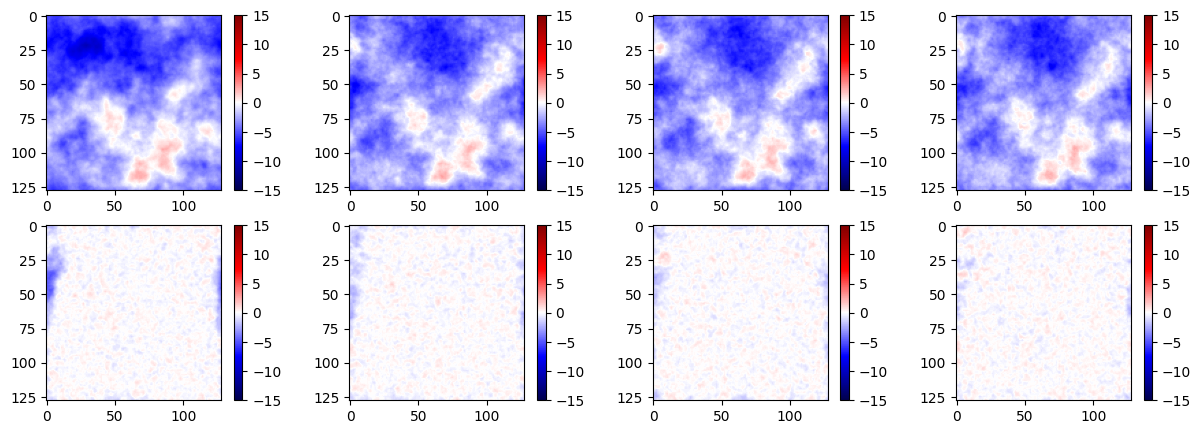

In [51]:
GAMMA = 0.1

x = sample0['x']
y = net.cuda().double().embed1(torch.tensor(x).cuda().double().unsqueeze(0))[0]
pk = lambda k: 1e6*3*(k/0.5)**-4.025
prior = sim.powersampler.get_prior_Q_factors(pk)
prior = (prior[0], prior[1].cuda(), prior[2])
x0 = net.lre1.get_MAP(y, prior, gamma = GAMMA)
draws = net.lre1.get_noise_samples_GEDA(300, prior, steps = 1000, reset = True, gamma = GAMMA)
bounds1 = [(x0.view(NPIX, NPIX).cpu().detach() + draws[i].view(NPIX, NPIX).cpu()).numpy() for i in range(len(draws))]
bounds1 = np.array(bounds1)

v = 15
plt.figure(figsize = (15, 5))
for i in range(4):
    plt.subplot(2, 4, i+1)
    if i == 0:
        plt.imshow(sample0['delta1'], cmap = 'seismic', vmin = -v, vmax = v)
    else:
        plt.imshow(bounds1[i], vmin = -v, vmax = v, cmap = 'seismic')
    plt.colorbar()    
res = [(x0.view(NPIX, NPIX).cpu().detach()*0 + draws[i].view(NPIX, NPIX).cpu()).numpy() for i in range(len(draws))]
for i in range(4):
    plt.subplot(2, 4, i+1+4)
    plt.imshow(res[i], vmin = -v, vmax = v, cmap = 'seismic')
    plt.colorbar()

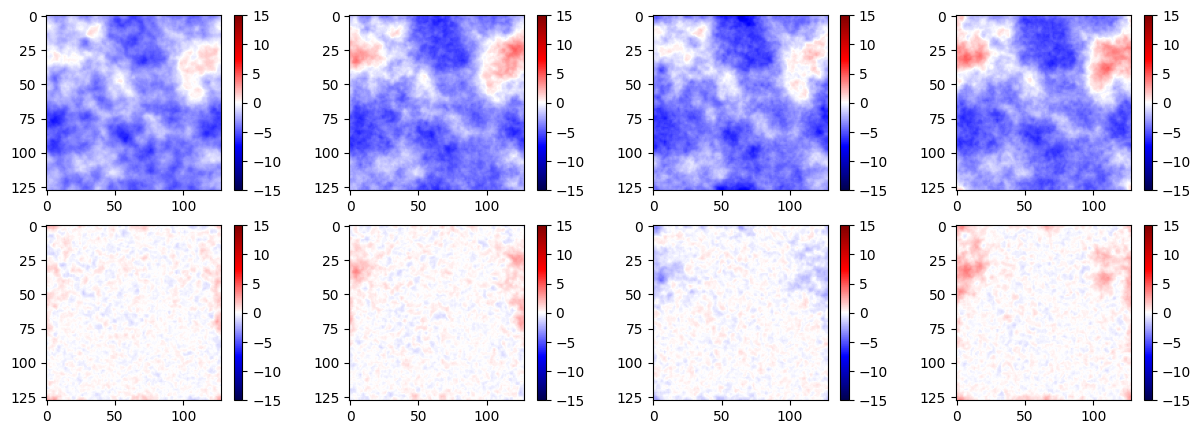

In [52]:
GAMMA = 0.1

x = sample0['x']
y = net.cuda().double().embed2(torch.tensor(x).cuda().double().unsqueeze(0))[0]
pk = lambda k: 1e6*3*(k/0.5)**-4.025
prior = sim.powersampler.get_prior_Q_factors(pk)
prior = (prior[0], prior[1].cuda(), prior[2])
x0 = net.lre2.get_MAP(y, prior, gamma = GAMMA)
draws = net.lre2.get_noise_samples_GEDA(300, prior, steps = 1000, reset = True, gamma = GAMMA)
bounds2 = [(x0.view(NPIX, NPIX).cpu().detach() + draws[i].view(NPIX, NPIX).cpu()).numpy() for i in range(len(draws))]
bounds2 = np.array(bounds2)

v = 15
plt.figure(figsize = (15, 5))
for i in range(4):
    plt.subplot(2, 4, i+1)
    if i == 0:
        plt.imshow(sample0['delta2'], cmap = 'seismic', vmin = -v, vmax = v)
    else:
        plt.imshow(bounds2[i], vmin = -v, vmax = v, cmap = 'seismic')
    plt.colorbar()    
res = [(x0.view(NPIX, NPIX).cpu().detach()*0 + draws[i].view(NPIX, NPIX).cpu()).numpy() for i in range(len(draws))]
for i in range(4):
    plt.subplot(2, 4, i+1+4)
    plt.imshow(res[i], vmin = -v, vmax = v, cmap = 'seismic')
    plt.colorbar()